![](1.jpg)

In [167]:
from __future__ import print_function, division
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  #这是一个可视化的展示库
import random
from sklearn.ensemble import RandomForestRegressor
import sklearn.preprocessing as preprocessing
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

In [168]:
#直接使用pandas对数据进行直观展示观看
data=pd.read_csv('G:\Machine-learning\\tensorflow-train-project(jupyter)\kaggele-project6-tairanprediction\dataset\\train.csv')
print(data.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


# 前置函数部分
这里会先准备好补全信息函数(对缺失值的考虑十分重要)，属性值转换函数，数据归一化函数。

In [197]:
#年龄信息补全函数：  这里 使用的方式是RandomForesetClassifier来填补
def set_missing_ages(data):
    age_df=data[['Age','Fare','Parch','SibSp','Pclass']]  #抽取一部分特征作为年龄相关特征时使用  这里使用五个特征[年龄、船票价格、父母子女数、经济状况]
    #print('age_df:',age_df)
    known_age=age_df[age_df.Age.notnull()].as_matrix()#   这是一种抽离，把知道年龄的数据抽取出来作为一个 矩阵，这个矩阵有包括上面的5个特征值
    #print('known_age:',known_age)
    unknown_age=age_df[age_df.Age.isnull()].as_matrix()  
    
    #接下来使用的事RandomForestClassifier算法来补全年龄特征，这里补全特征的思路是  使用除年龄外的其他特征来作为补全年龄的依据
    y=known_age[:,0]
    x=known_age[:,1:]
    #创建补全算法，并进行数据喂养  随机森林中参数意义为：n_estimators 子模型个数  random_state指定随机器对象 参数可参考https://www.cnblogs.com/amberdata/p/7203632.html  
    rfr=RandomForestRegressor(random_state=0,n_estimators=2000,n_jobs=-1)
    rfr.fit(x,y)
    #使用训练好的随机森林进行预测
    predictedAges=rfr.predict(unknown_age[:,1::])#对不知道年龄的矩阵，使用其特征进行年龄的预测
    data.loc[(data.Age.isnull()),'Age']=predictedAges#这是针对DateFrame的定位并填充残缺值的方式
    return data

In [198]:
#将属性转换为数值的函数
def attribute_to_number(data):
    #前三行会对属性进行独热编码
    dummies_Pclass=pd.get_dummies(data['Pclass'],prefix='Pclass')#get_dummies会对属性进行独热编码
    dummies_Embarked=pd.get_dummies(data['Embarked'],prefix='Embarked')
    dummies_Sex=pd.get_dummies(data['Sex'],prefix='Sex')
    #这里会将独热编码结果放到  组合结果的后面
    data=pd.concat([data,dummies_Pclass,dummies_Embarked,dummies_Sex],axis=1) #concat不管列名,直接加到一起,可以加到后面、也可以加到右边,axis=0为加到后面,axis=1为加到右边
    #针对这个类型，将前面没用的非数值属性去掉(使用后面新加入的 转化好的属性即可)
    data.drop(['Pclass','Sex','Embarked'],axis=1,inplace=True)
    return data
#对属性值进行归一化操作
def Scales(data):
    scaler=preprocessing.StandardScaler()#StandardScaler用于数据标准化，计算训练集的平均值和标准差,以便测试数据集使用相同的变换
    #对年龄进行归一化处理
    age_scale_param=scaler.fit(data['Age'].reshape(-1,1))#这样转换，使其具有0均值，单位方差
    data['Age_scaled']=scaler.fit_transform(data['Age'].reshape(-1,1),age_scale_param)#fit_transform可以进行最大最小的标准化
    #对工资进行归一化处理
    Fare_scale_param=scaler.fit(data['Fare'].reshape(-1,1))
    data['Fare_scaled']=scaler.fit_transform(data['Fare'].reshape(-1,1),Fare_scale_param)
    #对兄弟配偶数进行归一化处理
    SibSp_scale_param=scaler.fit(data['SibSp'].reshape(-1,1))
    data['SibSp_scaled']=scaler.fit_transform(data['SibSp'].reshape(-1,1),SibSp_scale_param)
    #对父母子女数进行归一化处理
    Parch_scale_param=scaler.fit(data['Parch'].reshape(-1,1))
    data['Parch_scaled']=scaler.fit_transform(data['Parch'].reshape(-1,1),SibSp_scale_param)
    #使用归一化后的数据，将之前的数据删去
    data.drop(['Parch','SibSp','Fare','Age'],axis=1,inplace=True)
    return data

# 第一部分
读取数据集之后，现在我们进行数据的预处理，预处理包括提取主要特征（这里经过我们思考，感觉年龄和性别以及座位等级也许是比较中的特征信息，因此我们会将多余的信息删去）、补全数据、数据的归一化这些思路

In [199]:
def DataPreProcess(in_data,submat_flg):#数据预处理    submat_flg为1表示是针对测试数据的处理
    #核心的几个预处理操作，有些函数需要自己手动去写
    in_data.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True) #删去无关特征
    data_ages_fitted=set_missing_ages(in_data)#补足年龄信息
    data=attribute_to_number(data_ages_fitted)#类目属性转为数值型
    data_scaled=Scales(data)#将转化为数值型的特征数据进行归一化
    
    #对特征数据和标签数据的划分   进行划分后作为新的数据返回
    data_copy=data_scaled.copy(deep=True)  #将数据集进行完全的备份   深拷贝
    data_copy.drop(['Pclass_1','Pclass_2','Pclass_3','Embarked_C','Embarked_Q','Embarked_S','Sex_female','Sex_male','Age_scaled','Fare_scaled','SibSp_scaled','Parch_scaled'],axis=1,inplace=True)
    data_y=np.array(data_copy)#这里是删去了很多东西(进行一种选择性的删除，还有axis这个自己不太掌握)   剩下的作为y的标签
    if submat_flg==0:
        data_scaled.drop(['Survived'],axis=1,inplace=True)
        data_X=np.array(data_scaled)#特征组合x，这是要进行网络输入所用的所有特征值
        return data_X,data_y
    if(submat_flg==1):
        data_X=np.array(data_scaled)#特征组合x，这是要进行网络输入所用的所有特征值
        return data_X,data_y
        

# 第二部分
创建计算图，使用逻辑回归算法根据预处理过的数据计算模型参数（纯套路，构建图，填充数据集）
我们打算使用逻辑回归法，要用到的式子为 $y=w0x0+w1x1+w2x2+b$  这样的方式求出其中的w和b，这是要计算出的模型参数

In [206]:
def LR(data_X,data_y):
    X_train,X_test,y_train,y_test=train_test_split(data_X,data_y,test_size=0.1,random_state=0)#按比例系数 划分训练集和测试集
    #接下来的操作应该是将标签值确定的转化为1或者0标签
    y_train=tf.concat([1-y_train,y_train],1)
    y_test=tf.concat([1-y_test,y_test],1)

    #设定参数和变量
    learning_rate=0.0005
    training_epochs=25
    batch_size=10
    display_step=10

    #获取喂养特征的样例数量和  使用的特征数量
    n_samples=X_train.shape[0]
    n_feature=X_train.shape[1]
    n_class=2#目标是进行二分类
    #设定占位符，模型变量和模型
    x=tf.placeholder(tf.float32,[None,n_feature])
    y=tf.placeholder(tf.float32,[None,n_class])
    W=tf.Variable(tf.zeros([n_feature,n_class]),name='weight')
    b=tf.Variable(tf.zeros([n_class]),name='bias')
    #创建计算模型
    pred=tf.matmul(x,W)+b    
    #计算准确率和损失函数
    correct_prediction=tf.equal(tf.arg_max(pred,1),tf.arg_max(y,1))
    accurary=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))#reduce_mean是针对张量求平均值的一种方式，而reduce_sum是针对的一种求和
    cost=tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred,labels=y))
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.9).minimize(cost)
    init=tf.initialize_all_variables()
    
    #开始创建计算图，并启动训练过程,在训练过程中观察准确率的变化
    with tf.Session() as sess:   
        sess.run(init)
        #进行50次训练批次的训练，每批次使用50个数据进行训练
        for epoch in range(training_epochs):
            avg_cost=0
            total_batch=int(n_samples/batch_size)   #在每个训练批次里面  我们都会使用所有的数据进行训练，所以这里会有个除式计算
            for i in range(total_batch):
                _,c=sess.run([optimizer,cost],feed_dict={x:X_train[i*batch_size:(i+1)*batch_size],y:y_train[i*batch_size:(i+1)*batch_size,:].eval()})
                avg_cost=c/total_batch#单批次下的损失值
            plt.plot(epoch+1,avg_cost,'co')#把损失值变化 用plt图标来展示出来
        
            if(epoch+1)%display_step==0:#达到一定批次之后进行准确的输出展示
                print('Epoch:',(epoch+1),',cost=',avg_cost)
               # print('the Weight: ',sess.run(W),'  ,the bias:',sess.run(b))
        X_test=sess.run(tf.convert_to_tensor(X_test))
        y_test=sess.run(tf.convert_to_tensor(y_test))
        print('Testing Accuracy:',sess.run(accurary,feed_dict={x:X_test,y:y_test}))#这个地方如果这样用，往feed_dict中传的是张量，这是tf的理解难点
        plt.xlabel('Epoch')
        plt.ylabel('cost')
        plt.show()
        W=sess.run(W)
        b=sess.run(b)
    return W,b

D:\ProgramData\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
D:\ProgramData\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
D:\ProgramData\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
D:\ProgramData\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
D:\ProgramData\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .

Epoch: 10 ,cost= 0.0994856476784
Epoch: 20 ,cost= 0.0937574744225
Testing Accuracy: 0.811111


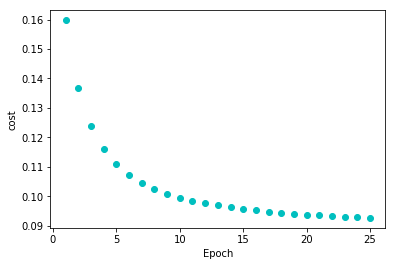

the W: Tensor("Placeholder_283:0", shape=(?, 2), dtype=float32) ,it type is <class 'tensorflow.python.framework.ops.Tensor'>
the b: [ 0.03232621 -0.03232621] ,it type is <class 'numpy.ndarray'>


In [207]:
#调用函数来启动计算过程  
if __name__=="__main__":
    data=pd.read_csv('G:\Machine-learning\\tensorflow-train-project(jupyter)\kaggele-project6-tairanprediction\dataset\\train.csv')
    submat_test_data=pd.read_csv('G:\Machine-learning\\tensorflow-train-project(jupyter)\kaggele-project6-tairanprediction\dataset\\test.csv')
    submat_test_data_PassengerId=submat_test_data['PassengerId']
    data_x,data_y=DataPreProcess(data,0)
    submat_test_data_x,submat_test_data_y=DataPreProcess(submat_test_data,1)
    Weight,bias=LR(data_x,data_y)
    print('the W:',W,',it type is',type(W))
    print('the b:',b,',it type is',type(b))
    

In [208]:
#使用计算得到的W和b参数重新启动计算过程     在会话中进行获救结果的预测，并保持在一个csv文件中
#创建计算图点
n_features=submat_test_data_x.shape[1]
n_Weight=Weight.shape[1]
n_bias=bias.shape
X=tf.placeholder(tf.float32,[None,n_features])
W=tf.placeholder(tf.float32,[None,n_Weight])
B=tf.placeholder(tf.float32,n_bias)#因为是一维的直接放置就行了
yHat=tf.add(tf.matmul(X,W),B)
last_result=tf.arg_max(yHat,1)   #构建计算图，直接放置即可    自己想出来的方法
with tf.Session() as sess2:
    tf.global_variables_initializer().run()
    submat_test_data_x=sess2.run(tf.convert_to_tensor(submat_test_data_x))
    Weight=sess2.run(tf.convert_to_tensor(Weight))
    bias=sess2.run(tf.convert_to_tensor(bias))
    print('submat shape:',submat_test_data_x.shape)
    print('Weight shape:',Weight.shape)
    print('bias shape:',type(bias))
    predictions_to=sess2.run([last_result],feed_dict={X:submat_test_data_x,W:Weight,B:bias})#np.argmax用于得到数组最大值的索引  整体获得预测结果
    #predictions_to=sess2.run(tf.arg_max(tf.convert_to_tensor(predictions),1))
    #print('predictions:',predictions_to[0].shape)
submission=pd.DataFrame({'PassengerId':submat_test_data_PassengerId,'Survived':predictions_to[0]})#构造一个表，用于放置预测结果    predictions_to[0]语句相当于把这取出来了
submission.to_csv('submit.csv',index=False)

submat shape: (418, 12)
Weight shape: (12, 2)
bias shape: <class 'numpy.ndarray'>
